# Práctica 4: Modelos del Lenguaje Neuronales

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

### Extra (0.5 pts):

- Correr el modelo de Bengio pero aplicando una técnica de subword tokenization al corpus y hacer generación del lenguaje

* La generación del lenguaje debe ser secuencias de palabras (no subwords)

#Contexto

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import reuters, stopwords
import re

# Descargar recursos necesarios
nltk.download('reuters')
nltk.download('stopwords')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Obtencion del coprus y vocabulario

In [ ]:
def preprocess_corpus(corpus):
    """Preprocesamiento como en el código original"""
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

# Reconstruir corpus
corpus = preprocess_corpus(reuters.sents())

# Construir vocabulario
words_freqs = Counter()
for sentence in corpus:
    words_freqs.update(sentence)

# Filtrar palabras raras (hapax legomena) y crear vocabulario
vocab = [word for word, count in words_freqs.items() if count > 1]
vocab.append("<UNK>")  # Token para palabras desconocidas

# Crear mapeos
words_indexes = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for idx, word in enumerate(vocab)}

#Configuración del modelo

In [ ]:
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
H = 100
V = len(vocab)  # Tamaño del vocabulario

class TrigramModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = torch.nn.Linear(context_size * embedding_dim, h)
        self.linear2 = torch.nn.Linear(h, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((-1, self.context_size * self.embedding_dim))
        out = torch.tanh(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = torch.nn.functional.log_softmax(out, dim=1)
        return log_probs

#Carga del modelo entrenado

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/Tareas_Datos/PLN_Practica_4/model_cuda_epoch_9.dat"

model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

TrigramModel(
  (embeddings): Embedding(20056, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20056, bias=True)
)

#Extracción de los embeddings

In [ ]:
def get_word_embeddings(model, words_indexes):
    embeddings = np.zeros((len(words_indexes), model.embeddings.weight.shape[1]))
    for word, idx in words_indexes.items():
        embeddings[idx] = model.embeddings.weight[idx].detach().cpu().numpy()
    return embeddings

word_embeddings = get_word_embeddings(model, words_indexes)

In [ ]:
def print_word_embedding(word, word_embeddings, words_indexes, decimals=4, max_length=10):
    """
    Imprime el embedding de una palabra específica con formato legible

    Args:
        word: Palabra a buscar
        word_embeddings: Matriz de embeddings (np.array)
        words_indexes: Diccionario {palabra: índice}
        decimals: Número de decimales a mostrar
        max_length: Máxima longitud del vector a mostrar (recorta si es muy largo)
    """
    if word not in words_indexes:
        print(f"Embedding para '{word}': Palabra no encontrada en el vocabulario")
        return

    idx = words_indexes[word]
    embedding = word_embeddings[idx]

    # Formatear el vector
    embedding_str = np.array2string(
        embedding[:max_length],  # Mostrar solo los primeros componentes
        precision=decimals,
        suppress_small=True,
        separator=', '
    )

    if len(embedding) > max_length:
        embedding_str = embedding_str[:-1] + f", ...]  # +{len(embedding)-max_length} componentes más"

    print(f"Embedding para '{word}': {embedding_str}")
    print(f"Dimensión total: {len(embedding)} componentes")

# Ejemplo de uso:
test_words = ["market", "price", "the", "bank"]
for word in test_words:
    print_word_embedding(word, word_embeddings, words_indexes)
    print("-" * 60)

Embedding para 'market': [-1.1112, -1.7428,  1.2083,  1.3825,  0.3156, -1.0765,  1.8086,  1.8499,
 -0.5272,  0.4128, ...]  # +190 componentes más
Dimensión total: 200 componentes
------------------------------------------------------------
Embedding para 'price': [-0.8053,  0.3556,  1.0068, -0.5046, -0.7017,  2.257 , -0.5499, -0.6252,
 -0.8925, -0.9301, ...]  # +190 componentes más
Dimensión total: 200 componentes
------------------------------------------------------------
Embedding para 'the': [-0.1121, -0.0177, -0.4475, -0.0467,  1.2388, -0.2453, -0.3374, -0.0879,
  0.2613, -0.0589, ...]  # +190 componentes más
Dimensión total: 200 componentes
------------------------------------------------------------
Embedding para 'bank': [ 1.7291,  0.1676, -0.0043, -1.1091,  2.1571, -1.0663, -0.5857,  0.1578,
 -1.4446,  0.3505, ...]  # +190 componentes más
Dimensión total: 200 componentes
------------------------------------------------------------


#Visualización de los embbedings

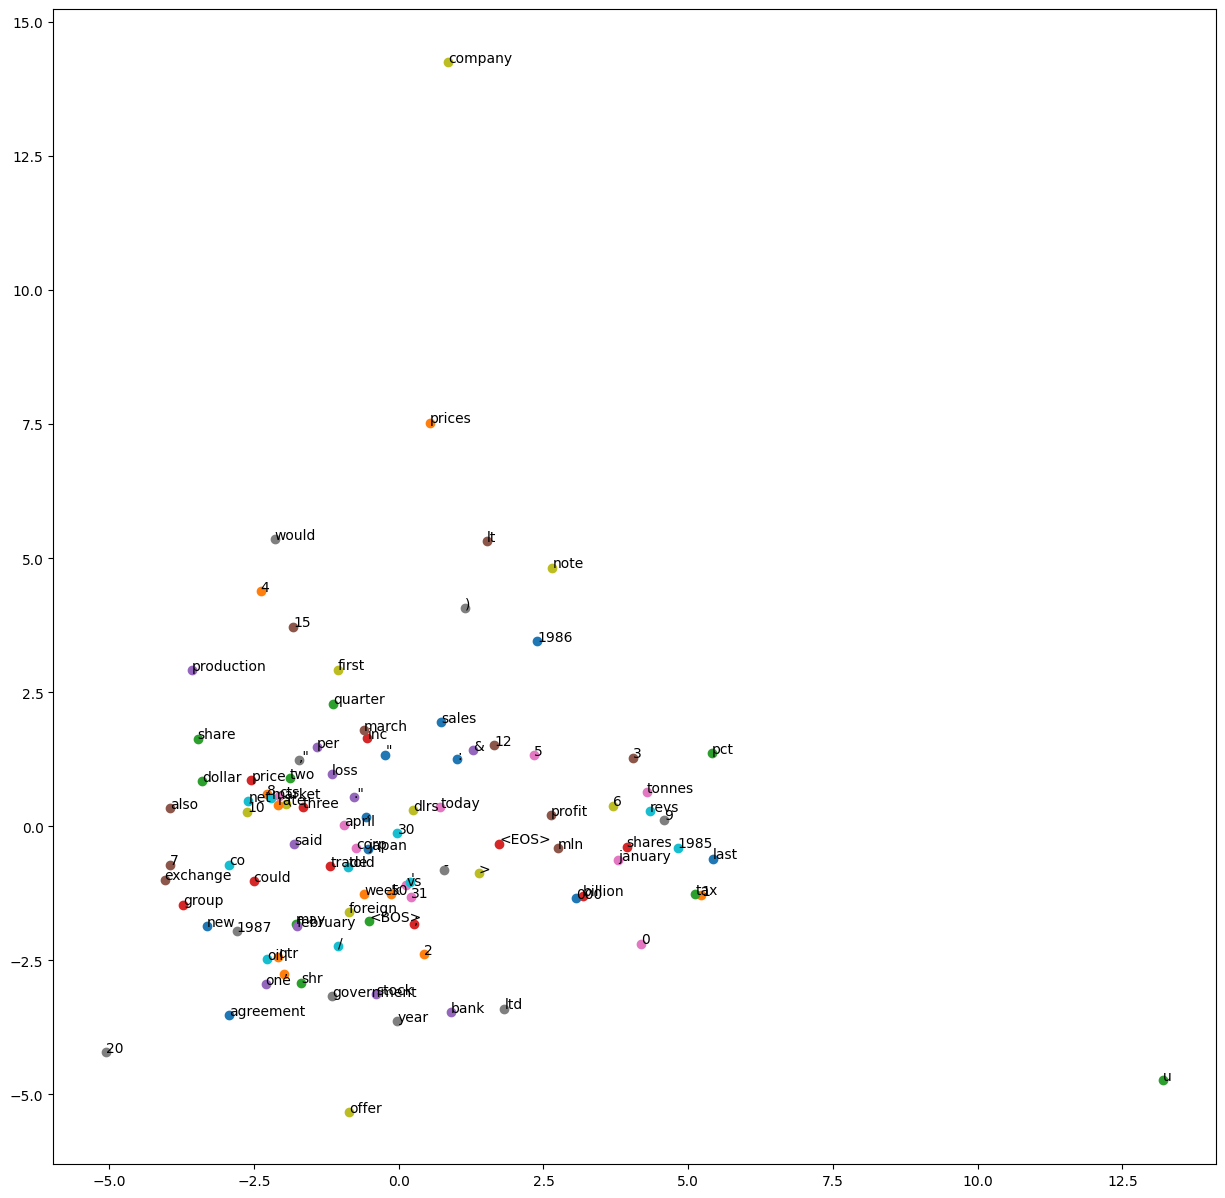

In [ ]:
def visualize_embeddings(embeddings, words_indexes, index_to_word, top_n=100):
    stop_words = set(stopwords.words('english'))

    # Obtener palabras más frecuentes (excluyendo stopwords)
    word_counts = Counter()
    for sent in corpus:
        for word in sent:
            if word.lower() not in stop_words and word in words_indexes:
                word_counts[word] += 1

    top_words = [word for word, _ in word_counts.most_common(top_n)]
    word_indices = [words_indexes[word] for word in top_words]

    # Reducir dimensionalidad
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings[word_indices])

    # Visualizar
    plt.figure(figsize=(15, 15))
    for i, word in enumerate(top_words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.show()

visualize_embeddings(word_embeddings, words_indexes, index_to_word)

Esta visualización revela una estructura semántica coherente, donde términos relacionados con finanzas, producción y economía se agrupan adecuadamente, lo cual indica que el modelo ha capturado relaciones contextuales relevantes. Entre lo positivo destaca la clara separación de conceptos y la agrupación temática de palabras clave como “profit”, “sales” o “tonnes”, lo que puede ser útil para tareas de análisis de texto o clasificación temática. Sin embargo, también se observan aspectos negativos como la presencia de tokens poco informativos lo que sugiere un preprocesamiento incompleto que podría afectar la calidad general del embedding. Además, algunas palabras clave aparecen aisladas, como “company” o “offer”, lo que podría deberse a su alta frecuencia o ambigüedad contextual, lo que limita su interpretación dentro del espacio reducido.


#Similitud semántica

In [ ]:
def get_similar_words(model, word, words_indexes, index_to_word, top_n=5):
    if word not in words_indexes:
        return []

    word_vec = model.embeddings.weight[words_indexes[word]].detach().cpu().numpy().reshape(1, -1)
    all_embeddings = model.embeddings.weight.detach().cpu().numpy()
    similarities = cosine_similarity(word_vec, all_embeddings)[0]

    most_similar = np.argsort(-similarities)[1:top_n+1]  # Excluir la palabra misma
    return [(index_to_word[idx], similarities[idx]) for idx in most_similar]

# Ejemplos de similitud
print("Palabras similares a 'market':")
print(get_similar_words(model, "market", words_indexes, index_to_word))

print("\nPalabras similares a 'company':")
print(get_similar_words(model, "company", words_indexes, index_to_word))

print("\nPalabras similares a 'man':")
print(get_similar_words(model, "man", words_indexes, index_to_word))

print("\nPalabras similares a 'cat':")
print(get_similar_words(model, "cat", words_indexes, index_to_word))

print("\nPalabras similares a 'dog':")
print(get_similar_words(model, "dog", words_indexes, index_to_word))

Palabras similares a 'market':
[('designed', np.float32(0.2756334)), ('supplies', np.float32(0.2712138)), ('fire', np.float32(0.27092084)), ('concerning', np.float32(0.26355255)), ('sa', np.float32(0.2624887))]

Palabras similares a 'company':
[('target', np.float32(0.3781963)), ('interpreted', np.float32(0.3377508)), ('priorities', np.float32(0.3366778)), ('affair', np.float32(0.3199518)), ('rout', np.float32(0.30751297))]

Palabras similares a 'man':
[('salary', np.float32(0.32821894)), ('contradictory', np.float32(0.27722988)), ('jard', np.float32(0.2762207)), ('segment', np.float32(0.2671749)), ('fleets', np.float32(0.26644933))]

Palabras similares a 'cat':
[('kleckner', np.float32(0.25214735)), ('asm', np.float32(0.24725884)), ('szynkarsky', np.float32(0.2420156)), ('ltd', np.float32(0.23905207)), ('susumu', np.float32(0.23504724))]

Palabras similares a 'dog':
[('follows', np.float32(0.31987202)), ('dependency', np.float32(0.3065017)), ('punitive', np.float32(0.30501518)), ('sil

El embedding captura relaciones razonables en términos financieros o empresariales, pero falla en representar conceptos generales como 'man', 'dog' o 'cat', reflejando las limitaciones de un corpus especializado como Reuters.

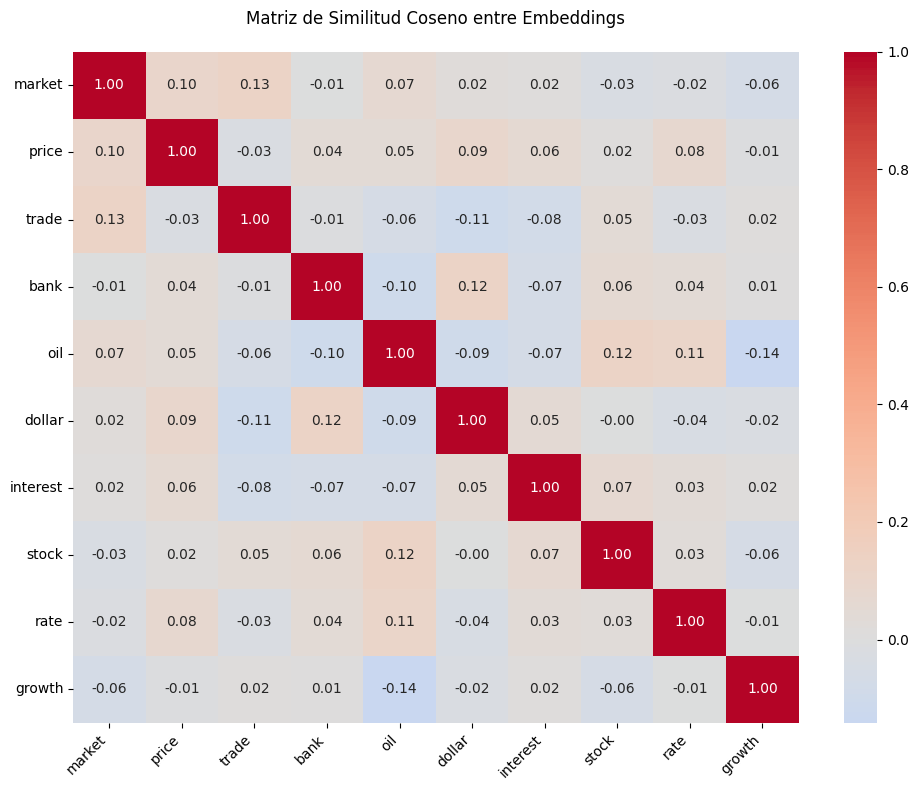

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_similarity_matrix(model, words_list, words_indexes, index_to_word):
    """
    Muestra una matriz de similitud coseno entre las palabras en words_list
    Args:
        model: Modelo de PyTorch con embeddings
        words_list: Lista de palabras a comparar
        words_indexes: Diccionario {palabra: índice}
        index_to_word: Diccionario {índice: palabra}
    """
    # Filtrar palabras que no están en el vocabulario
    valid_words = [word for word in words_list if word in words_indexes]

    if not valid_words:
        print("Ninguna palabra válida encontrada en el vocabulario.")
        return

    # Obtener embeddings para las palabras válidas
    word_indices = [words_indexes[word] for word in valid_words]
    embeddings = model.embeddings.weight[word_indices].detach().cpu().numpy()

    # Calcular matriz de similitud coseno
    similarity_matrix = cosine_similarity(embeddings)

    # Configurar el gráfico
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                annot=True,
                fmt=".2f",
                cmap="coolwarm",
                center=0,
                xticklabels=valid_words,
                yticklabels=valid_words)

    plt.title("Matriz de Similitud Coseno entre Embeddings", pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con palabras del dominio económico/financiero (Reuters)
economic_words = ["market", "price", "trade", "bank", "oil", "dollar", "interest", "stock", "rate", "growth"]
plot_similarity_matrix(model, economic_words, words_indexes, index_to_word)

La matriz revela que los embeddings sí capturan algunas asociaciones semánticas razonables dentro del dominio financiero, pero de forma superficial o débil.